In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import bloscpack as bp

import sys
import os
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from annotation_utilities import *
from registration_utilities import *
from vis3d_utilities import *
from metadata import *
from data_manager import *

import time

import matplotlib.pyplot as plt
%matplotlib inline

Setting environment for Local Macbook Pro


In [2]:
atlas_name = 'atlasV5'

# Genrate mesh for subject volume mapped back to atlas space

In [3]:
classifier_setting = 2

In [9]:
warp_setting = 3

In [9]:
# Render globally transformed atlas structures

for stack in all_nissl_stacks:
# for stack in ['MD590']:
    
    for structure in all_known_structures_sided:
#     for structure in ['7N_L']:

        print structure
        
        try:
            reversed_volume = \
        DataManager.load_transformed_volume(stack_m=atlas_name, stack_f=stack,
                                           classifier_setting_m=classifier_setting,
                                           classifier_setting_f=classifier_setting,
                                           warp_setting=warp_setting,
                                           structure=structure)

        #     xmin, xmax, ymin, ymax, zmin, zmax = bbox_3d(reversed_volume)
        #     vol = reversed_volume[ymin:ymax+1, xmin:xmax+1, zmin:zmax+1]

        #     dense_vol = fill_sparse_score_volume(vol)

            t = time.time()

            polydata = volume_to_polydata(reversed_volume, origin=(0,0,0), num_simplify_iter=3, smooth=True, level=.5)

            sys.stderr.write('time: %.2f\n' % (time.time() - t)) # 10s

            mesh_fn = DataManager.get_transformed_volume_mesh_filepath(stack_m=atlas_name, stack_f=stack,
                                                                      classifier_setting_m=classifier_setting,
                                                                      classifier_setting_f=classifier_setting,
                                                                      warp_setting=warp_setting,
                                                                      structure=structure)

            save_mesh(polydata, mesh_fn)
            
        except Exception as e:
            sys.stderr.write('%s\n' % e)
            sys.stderr.write('Error transforming volume %s.\n' % structure)

5N_L


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/usr/lib/python2.7/inspect.py", line 1049, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/usr/lib/python2.7/inspect.py", line 1009, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/usr/lib/python2.7/inspect.py", line 454, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File "/usr/lib/python2.7/inspect.py", line 497, in getmodule
    f = getabsfile(module)
  File

IndexError: string index out of range

# Load

In [ ]:
# AtlasV2

# Load locally transformed atlas structure meshes

reversed_polydata_list = {stack: \
                          DataManager.load_meshes(stack_m=atlas_name, stack_f=stack,
                                                                   classifier_setting_m=classifier_setting,
                                                                   classifier_setting_f=classifier_setting,
                                                                   warp_setting=warp_setting,
                                                                   return_polydata_only=True,
                                                                    sided=True)
                          for stack in all_nissl_stacks}

In [ ]:
for st, x in reversed_polydata_list.iteritems():
    print st, '\t', set(all_known_structures_sided) - set(x.keys())

In [3]:
# MD589 annotation volume bbox.

ann_vol_xmin_rel2uncropped, ann_vol_xmax_rel2uncropped, \
ann_vol_ymin_rel2uncropped, ann_vol_ymax_rel2uncropped, \
ann_vol_zmin_rel2uncropped, ann_vol_zmax_rel2uncropped = \
DataManager.load_original_volume_bbox('MD589', volume_type='annotation')

In [110]:
all_reversed_structure_actors = {st: [actor_mesh(p, 
                       wireframe=False, 
#                        color=structure_colors[convert_name_to_unsided(n)]/255., 
#                         color=(0,1,0), 
#                         color=stack_colors[st]/255.,
                        color=map_name_u_to_color[convert_to_original_name(n)]/255.,
                        opacity=.3,
                      origin=(ann_vol_xmin, 
                              ann_vol_ymin, 
                              ann_vol_zmin))
                                      for n, p in ps.iteritems() if n not in outliers or st not in outliers[n]]
            for st, ps in reversed_polydata_list.iteritems()
                                if st in all_nissl_stacks}

In [36]:
# Diff. structure diff. opacity.

def map_name_to_opacity(name):
    if name in ['7N_L', '7N_R', '5N_L', '5N_R', '12N', 'Pn_L', 'Pn_R', 'LC_L', 'LC_R', 'Amb_L', 'Amb_R',
               'Tz_L', 'Tz_R', '3N_L', '3N_R', '4N_L', '4N_R', 'RMC_L', 'RMC_R', '10N_L', '10N_R']:
        opacity = .5
    else:
        opacity = 0.01
    return opacity

all_reversed_structure_actors = {st: [actor_mesh(p, 
                       wireframe=False, 
#                        color=structure_colors[convert_name_to_unsided(n)]/255., 
#                         color=(0,1,0), 
#                         color=stack_colors[st]/255.,
                        color=map_name_u_to_color[convert_to_original_name(n)]/255.,
                        opacity=map_name_to_opacity(n),
                      origin=(ann_vol_xmin, 
                              ann_vol_ymin, 
                              ann_vol_zmin))
                                      for n, p in ps.iteritems() if n not in outliers or st not in outliers[n]]
            for st, ps in reversed_polydata_list.iteritems()
                                if st in all_nissl_stacks}

# Identify Outliers

In [129]:
outliers = {st: [] for st in all_nissl_stacks}

outliers = {}
with open('/home/yuncong/Brain/outliers.txt', 'r') as f:
    for line in f.readlines():
        elements = line.split()
        outliers[elements[0]] = elements[1:]
        
# outliers['Sp5C_L'] = ['MD602', 'MD593', 'MD595', 'MD603', 'MD599']
# outliers['5N_L'] = ['MD603']

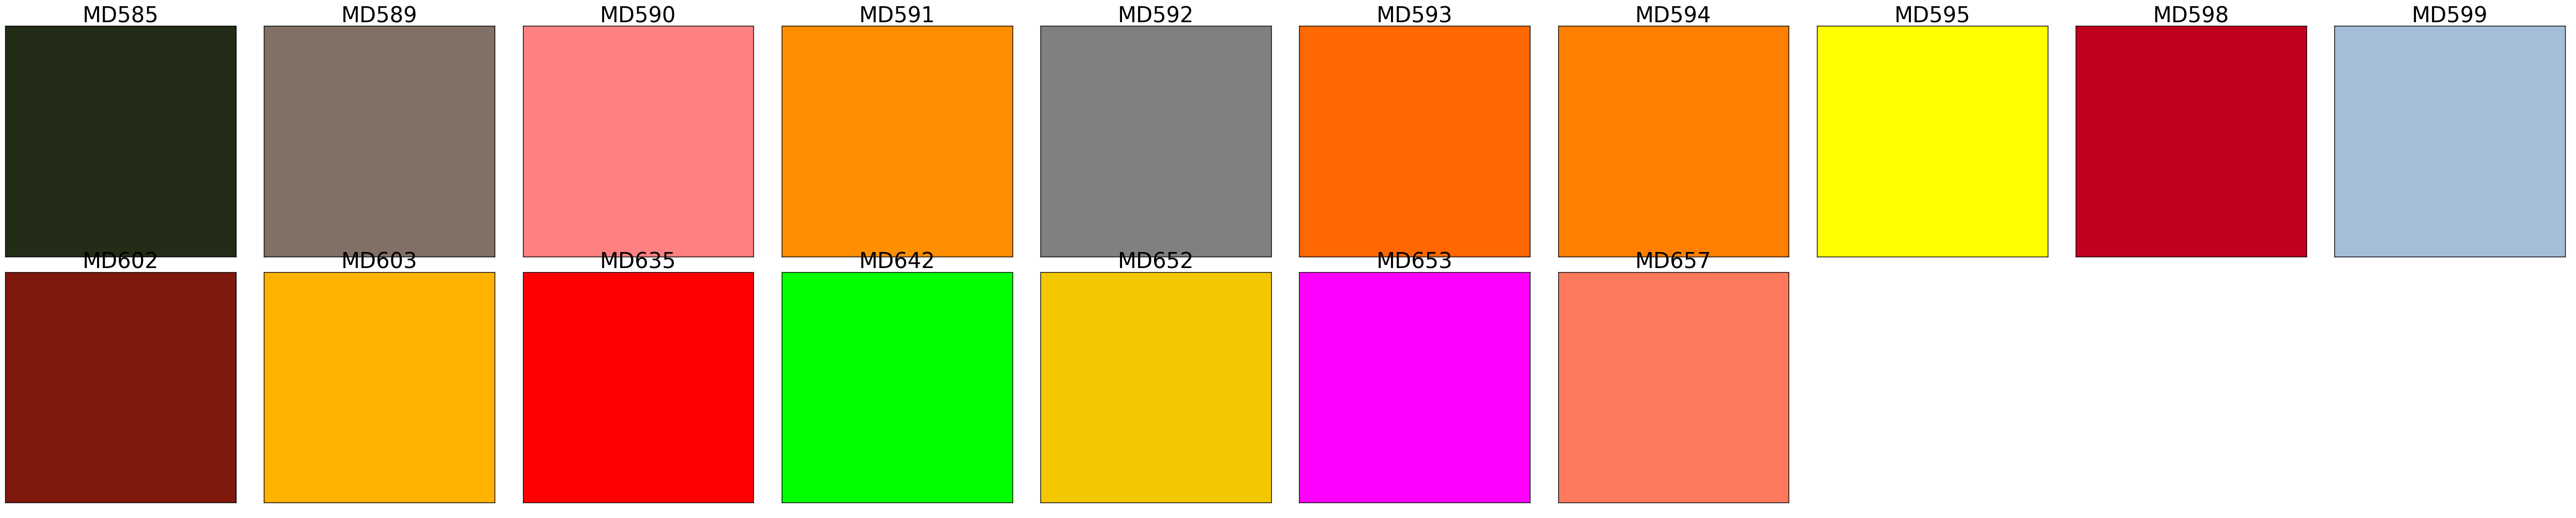

In [130]:
# Stack color table

titles = sorted(stack_colors.keys())
vizs = []
for s, c in sorted(stack_colors.items()):
    v = np.zeros((1,1,3))
    v[:, :] = np.array(c/255.)
    vizs.append(v)
    
display_images_in_grids(vizs, nc=10, titles=titles)

In [131]:
# names_of_interest = ['7N_L', '7N_R', '5N_L', '5N_R', '12N', 'Tz_L', 'Tz_R', '7n_L', '7n_R', 'LRt_L', 'LRt_R',
#                     'Pn_L', 'Pn_R', 'SNR_L', 'SNR_R']

# names_of_interest = ['7N_L']
# names_of_interest = ['Sp5C_R']
names_of_interest = ['5N_L']

# names_of_interest = [n for n in structures_sided \
#                      if '_L' not in n and \
#                      convert_name_to_unsided(n) not in ['AP', 'DC', 'Sp5O', 'Sp5I', 'Sp5C', 'RtTg', 'VCP', 'VCA']]

particular_reversed_structure_actors_all = {}

for name_s_interest in names_of_interest:
    
    if name_s_interest in outliers:
        print 'Outlier stack for %s:' % name_s_interest, outliers[name_s_interest]
        
    particular_reversed_structure_actors = [actor_mesh(p, 
                           wireframe=True, 
    #                        color=structure_colors[convert_name_to_unsided(n)]/255., 
                            color=stack_colors[st]/255.,
                           opacity=1.,
                          origin=(ann_vol_xmin, 
                                  ann_vol_ymin, 
                                  ann_vol_zmin))
                for st, ps in reversed_polydata_list.iteritems() for n, p in ps.iteritems() 
                                            if n == name_s_interest and \
                                            (name_s_interest not in outliers or st not in outliers[name_s_interest])]
    
    particular_reversed_structure_actors_all[name_s_interest] = particular_reversed_structure_actors
    
launch_vtk(
#     [all_atlas_structure_mesh_actors[n] for n in names_of_interest] + \
           [shell_actor] + \
           sum(particular_reversed_structure_actors_all.values(), []), init_angle='horizontal_topDown')

Outlier stack for 5N_L: ['MD602', 'MD603', 'MD592', 'MD591', 'MD594', 'MD589', 'MD599']


In [132]:
all_reversed_structure_actors = {st: [actor_mesh(p, 
                       wireframe=False, 
#                        color=structure_colors[convert_name_to_unsided(n)]/255., 
#                         color=(0,1,0), 
                        color=stack_colors[st]/255.,
                       opacity=.3,
                      origin=(ann_vol_xmin, 
                              ann_vol_ymin, 
                              ann_vol_zmin))
                                      for n, p in ps.iteritems() if n not in outliers or st not in outliers[n]]
            for st, ps in reversed_polydata_list.iteritems()}

In [133]:
launch_vtk(all_atlas_structure_mesh_actors.values() + all_reversed_structure_actors['MD602'] + \
           [shell_actor])

In [134]:
launch_vtk(all_atlas_structure_mesh_actors.values() + sum(all_reversed_structure_actors.values(), []) + \
           [shell_actor])

# Load marked neurons

In [3]:
atlas_name = 'atlasV5'

In [4]:
canonical_centroid_rel2uncropped = np.loadtxt(DataManager.get_atlas_canonical_centroid_filepath(atlas_name))

In [72]:
structure_meshes_rel2canon = DataManager.load_meshes(stack_m=atlas_name, sided=True, include_surround=False)

load_mesh_stl: File does not exist /home/yuncong/CSHL_meshes/atlasV5/atlasV5_down32_scoreVolume/atlasV5_down32_scoreVolume_sp5.stl
Error loading mesh for sp5: Mesh is empty: sp5..
load_mesh_stl: File does not exist /home/yuncong/CSHL_meshes/atlasV5/atlasV5_down32_scoreVolume/atlasV5_down32_scoreVolume_outerContour.stl
Error loading mesh for outerContour: Mesh is empty: outerContour..


In [73]:
structure_sided_to_opacity = {}
for n in structure_meshes_rel2canon.iterkeys():
#     if n == '5N_L' or n == '7N_L':
    if n == 'SNR_L':
        opacity = .3
    elif parse_label(n)[1] != 'R': # left and singular structures
        opacity = .1
    else: # right side structures
        opacity = 0
#         opacity = .1
    structure_sided_to_opacity[n] = opacity

# structure_sided_to_opacity = {}
# for n in structure_meshes_rel2canon.iterkeys():
#     if n == '5N_L' or n == '7N_L':
#         opacity = .8
#     else:
#         opacity = .1
#     structure_sided_to_opacity[n] = opacity

In [74]:
structure_mesh_actors_rel2canon = {n: actor_mesh(polydata, np.array(name_unsided_to_color[convert_to_original_name(n)])/255.,
                                             wireframe=False, opacity=structure_sided_to_opacity[n]) 
                                   for n, polydata in structure_meshes_rel2canon.iteritems()}

In [75]:
shell_polydata_rel2uncropped = DataManager.load_shell_mesh(stack='MD589', downscale=32)
shell_actor_rel2canon = actor_mesh(shell_polydata_rel2uncropped, (1,1,1), opacity=.05, wireframe=False, 
                                   origin=-canonical_centroid_rel2uncropped)

In [76]:
atlas_vol_xmin_rel2uncropped, atlas_vol_xmax_rel2uncropped, \
atlas_vol_ymin_rel2uncropped, atlas_vol_ymax_rel2uncropped, \
atlas_vol_zmin_rel2uncropped, atlas_vol_zmax_rel2uncropped = \
DataManager.load_original_volume_bbox(stack=atlas_name, volume_type='score', structure='7N_L')

In [77]:
experiments = {
            'LM30': {'injection_structure': 'SNR_L', 'marker_color': (0,1,0)},
            'LM40': {'injection_structure': 'SNR_L', 'marker_color': (1,0,0)},
#             'MD661': {'injection_structure': '5N_L', 'marker_color': (1,0,0)},
#              'MD662': {'injection_structure': '7N_L', 'marker_color': (0,1,0)}
#               'MD658': {'injection_structure': '5N_L', 'marker_color': (0,0,1)}
              }

# experiments = {'MD658': {'injection_structure': '5N_L'}}

In [78]:
# Here we should use the overall deformable transform, in order to correctly 
# locate the marked neurons in structures other than the injection site.

In [79]:
stack_to_color['LM40'] = (0, 255, 255)
stack_to_color['LM30'] = (255, 255, 0)

In [88]:
marker_xyzs_rel2canonical_actors = {}
injection_sites_rel2canonical_actors = {}


for stack, experiment_info in experiments.iteritems():
    
    stack_bbox = DataManager.load_original_volume_bbox(stack=stack, structure='SNR_L', volume_type='annotationAsScore')
    
    injection_structure = experiment_info['injection_structure']
    
# Load regular format
#     markers_df = DataManager.load_annotation_v4(stack=stack, by_human=True, timestamp='latest', suffix='neurons')
#     markers_df_cropped = convert_annotation_v3_original_to_aligned_cropped(markers_df, stack=stack)
#     markers_df_cropped_sagittal = markers_df_cropped[(markers_df_cropped['orientation'] == 'sagittal')]
        
#     marker_xyzs_rel2subj = {}
#     for marker_id, marker_entry in markers_df_cropped_sagittal.iterrows():
#         xy = marker_entry['vertices'][0] / 32.
#         z = np.mean(DataManager.convert_section_to_z(stack, sec=marker_entry['section'], downsample=32))
#         marker_xyzs_rel2subj[marker_id] = (xy[0], xy[1], z)

    # Load Neurolucida format
    marker_xyzs_rel2subj = {}
    m = bp.unpack_ndarray_file('/home/yuncong/lauren_data/markers/%(stack)s/%(stack)s_markers_SNR_L.bp' % {'stack':stack})
    for marker_id, marker_xyz in enumerate(m):
        marker_xyzs_rel2subj[marker_id] = marker_xyz
        
    # Identify the structures of marked neurons based on transformed atlas
    
#     structures_to_query = ['5N_L', '7N_L', 'SNR_L']
#     valid_level = 0.5
    
#     neurons_per_structure = defaultdict(list)
    
#     for structure in structures_to_query:
#         warped_vol = DataManager.load_transformed_volume(stack_m=atlas_name, stack_f=stack, warp_setting=17, 
#                                         prep_id_f=2, detector_id_f=1, structure=structure)
#         for marker_id, (x, y, z) in marker_xyzs_rel2subj.iteritems():
#             if 0 <= int(y) and int(y) < warped_vol.shape[0] and \
#             0 <= int(x) and int(x) < warped_vol.shape[1] and \
#             0 <= int(z) and int(z) < warped_vol.shape[2]:
#                 if warped_vol[int(y), int(x), int(z)] > valid_level:
#                     neurons_per_structure[structure].append(marker_id)
                    
#     print {s: len(m_ids) for s, m_ids in neurons_per_structure.iteritems()}
    

    ###### Load local transform ######
    
    
#     ltx_params, l_centroid_m, l_centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
#     DataManager.load_alignment_parameters(stack_m=atlas_name, stack_f=stack, warp_setting=17, 
#                                       prep_id_f=2, detector_id_f=1, 
#                                       structure_m=injection_structure, structure_f=injection_structure)
    
#     marker_xyzs_rel2subj = dict(zip(marker_xyzs_rel2subj.keys(), 
#                                     transform_points_inverse(ltx_params, \
#                                                              pts_prime=marker_xyzs_rel2subj.values(), 
#                                                              c_prime=l_centroid_f, c=l_centroid_m)))

    ########## Load weighted-average transform parameters ##########
    
#     params_fp = DataManager.get_alignment_result_filepath(stack_m=atlas_name, stack_f=stack,
#                                         prep_id_f=2,
#                                         detector_id_f=1,                                                
#                                         warp_setting=19, 
#                                           what='parametersWeightedAverage')
#     download_from_s3(params_fp, redownload=True)
#     params = load_pickle(params_fp)

#     rigid_param_list = [component['RigidParameters'] for component in params]
#     anchor_points = [ component['Anchor'] for component in params]
#     sigmas = [component['Sigma'] for component in params]
#     weights = [component['Weight'] for component in params]
    
#     marker_xyzs_rel2subj = dict(zip(marker_xyzs_rel2subj.keys(), \
#                                     transform_points_polyrigid_inverse(marker_xyzs_rel2subj.values(),
#                                                                rigid_param_list, 
#                                                               anchor_points, 
#                                                               sigmas, 
#                                                               weights)))
    
    ##############################

#     gtx_params, g_centroid_m, g_centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
#     DataManager.load_alignment_parameters(stack_m=atlas_name, stack_f=stack, warp_setting=16, 
#                                       prep_id_f=2, detector_id_f=1)

    gtx_params, g_centroid_m, g_centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
    DataManager.load_alignment_parameters(stack_m=atlas_name, stack_f=stack, warp_setting=16)

#     gtx_params, g_centroid_m, g_centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
#     DataManager.load_alignment_parameters(stack_m=atlas_name, stack_f=stack, warp_setting=22, 
#                                           structure_f='SNR_L', structure_m='SNR_L')

    marker_xyzs_rel2atlas = dict(zip(marker_xyzs_rel2subj.keys(), 
                                     transform_points_inverse(gtx_params, \
                                                              pts_prime=marker_xyzs_rel2subj.values(), \
                                                              c_prime=g_centroid_f + stack_bbox[[0,2,4]], \
                                                              c=g_centroid_m)))

    ## Identify the structures of marked neurons based on them mapped back to atlas space ##
    
#     structures_to_query = ['5N_L', '7N_L', 'SNR_L']
    structures_to_query = ['SNR_L']
    valid_level = 0.5
    
    neurons_per_structure2 = defaultdict(list)

    for structure in structures_to_query:
        atlas_vol = DataManager.load_original_volume(stack=atlas_name, structure=structure, downscale=32)
        for marker_id, (x, y, z) in marker_xyzs_rel2atlas.iteritems():
            if 0 <= int(y) and int(y) < atlas_vol.shape[0] and \
            0 <= int(x) and int(x) < atlas_vol.shape[1] and \
            0 <= int(z) and int(z) < atlas_vol.shape[2]:
                if atlas_vol[int(y), int(x), int(z)] > valid_level:
                    neurons_per_structure2[structure].append(marker_id)
    
    ## Estimate injection site center and radius ##
    
    # This is NOT the smallest enclosing ball.
    # To find that, refer to https://github.com/weddige/miniball.
    
    injection_site_marker_coords_rel2atlas = np.array([marker_xyzs_rel2atlas[marker_id] for marker_id in neurons_per_structure2[injection_structure]])
    injection_site_centroid_rel2atlas = injection_site_marker_coords_rel2atlas.mean(axis=0)
    injection_site_centroid_rel2canonical = injection_site_centroid_rel2atlas + (atlas_vol_xmin_rel2uncropped, atlas_vol_ymin_rel2uncropped, atlas_vol_zmin_rel2uncropped) - canonical_centroid_rel2uncropped
    
    from scipy.spatial.distance import cdist
    injection_site_radius_all = cdist([injection_site_centroid_rel2atlas], injection_site_marker_coords_rel2atlas)
    injection_site_radius = injection_site_radius_all.max()
    injection_site_farthest = neurons_per_structure2[injection_structure][injection_site_radius_all.argmax()]
    
    injection_site_actor_rel2canonical = actor_sphere(position=injection_site_centroid_rel2canonical, 
                                        radius=injection_site_radius, 
                                        color=stack_to_color[stack], 
                                        opacity=1.)
    injection_sites_rel2canonical_actors[stack] = injection_site_actor_rel2canonical
    
    ## Adjust marker color and opacity based on structure assignment ###
    

# (Optional) only show a neurons within a ROI
#     qs = []
#     for injection_structure in ['5N_L', '7N_L']:
#         atlas_vol = DataManager.load_original_volume(stack=atlas_name, structure=injection_structure, downscale=32)
#         q = np.array(np.nonzero(atlas_vol))
#         qs.append(q)
#     q = np.hstack(qs)
#     roi_ymin, roi_xmin, roi_zmin = q.min(axis=1) - margin
#     roi_ymax, roi_xmax, roi_zmax = q.max(axis=1) + margin
    
    marker_id_to_color = {}
    marker_id_to_opacity = {}
    for marker_id in marker_xyzs_rel2atlas.keys():
#         if marker_id == injection_site_farthest:
#             marker_id_to_color[marker_id] = (0,0,1)
#             marker_id_to_opacity[marker_id] = 1.
        if marker_id in neurons_per_structure2[injection_structure]:
#             marker_id_to_color[marker_id] = (0,1,0)
            marker_id_to_color[marker_id] = experiments[stack]['marker_color']
            marker_id_to_opacity[marker_id] = 1.
#         elif marker_xyzs_rel2atlas[marker_id][0] > roi_xmin and \
#             marker_xyzs_rel2atlas[marker_id][0] < roi_xmax and \
#             marker_xyzs_rel2atlas[marker_id][1] > roi_ymin and \
#             marker_xyzs_rel2atlas[marker_id][1] < roi_ymax and \
#             marker_xyzs_rel2atlas[marker_id][2] > roi_zmin and \
#             marker_xyzs_rel2atlas[marker_id][2] < roi_zmax:
#             marker_id_to_color[marker_id] = experiments[stack]['marker_color']
#             marker_id_to_opacity[marker_id] = 1.    
        else:
            marker_id_to_color[marker_id] = experiments[stack]['marker_color']
            marker_id_to_opacity[marker_id] = .1
                    
    print {s: len(m_ids) for s, m_ids in neurons_per_structure2.iteritems()}

    ######################
        
    marker_xyzs_rel2canonical = dict(zip(marker_xyzs_rel2atlas.keys(), 
                                         np.array(marker_xyzs_rel2atlas.values()) + (atlas_vol_xmin_rel2uncropped, atlas_vol_ymin_rel2uncropped, atlas_vol_zmin_rel2uncropped) - canonical_centroid_rel2uncropped))
    marker_xyzs_rel2canonical_actors[stack] = [actor_sphere(position=(x,y,z), radius=1, 
                                                            color=marker_id_to_color[marker_id],
                                                            opacity=marker_id_to_opacity[marker_id]) 
                                   for marker_id, (x,y,z) in marker_xyzs_rel2canonical.iteritems()]

rm -rf "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp16_LM40_down32_scoreVolume/atlasV5_down32_scoreVolume_warp16_LM40_down32_scoreVolume_parameters.txt" && mkdir -p "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp16_LM40_down32_scoreVolume"
aws s3 cp "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp16_LM40_down32_scoreVolume/atlasV5_down32_scoreVolume_warp16_LM40_down32_scoreVolume_parameters.txt" "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp16_LM40_down32_scoreVolume/atlasV5_down32_scoreVolume_warp16_LM40_down32_scoreVolume_parameters.txt"
{'SNR_L': 15}
rm -rf "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp16_LM30_down32_scoreVolume/atlasV5_down32_scoreVolume_warp16_LM30_down32_scoreVolume_parameters.txt" && mkdir -p "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_

In [89]:
launch_vtk(
#     [structure_mesh_actors_rel2canon['5N_L']] + \
#     [structure_mesh_actors_rel2canon['7N_L']] + \
    structure_mesh_actors_rel2canon.values() + \
#     marker_xyzs_rel2canonical_actors['MD658'][::] + \
#     marker_xyzs_rel2canonical_actors['MD661'] + \
#     marker_xyzs_rel2canonical_actors['MD662'] + \
    marker_xyzs_rel2canonical_actors['LM30'] + \
    marker_xyzs_rel2canonical_actors['LM40'] + \
    [shell_actor_rel2canon] + \
#     [actor_sphere((0,0,0), radius=3, color=(0,0,0))],
#     [injection_sites_rel2canonical_actors['MD661']] + \
#     [injection_sites_rel2canonical_actors['MD662']] + \
    [],
    background_color=(1,1,1), 
    axes_label_color=(0,0,0), 
#     init_angle='coronal')
    init_angle='horizontal_topDown')
#     init_angle='sagittal')